In [12]:
import numpy as np
import torch
import torch.nn as nn

from dataset.ade20k import TestDataset
from config import cfg
from model.upernet.vit import vit_base
from model.upernet.upernet import uper
from model.upernet.segmentation import SegmentationModule

In [13]:
cfg.merge_from_file("config/ade20k-resnet50-upernet.yaml")

# Model
vit = vit_base(
    image_size=256,
    patch_size=16,
    num_classes=150,
)

upernet = uper(use_softmax=True)

crit = nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(vit, upernet, crit)
segmentation_module.load_state_dict(torch.load('../data/upernet_pretrain_epoch400.pth'))
segmentation_module.to('cpu')
segmentation_module.eval()
torch.set_grad_enabled(False)


In [14]:
def test(test_image_name):
  dataset_test = TestDataset([{'fpath_img': test_image_name}], cfg.DATASET, max_sample=-1)

  batch_data = dataset_test[0]
  segSize = (256, 256)
  img_resized_list = batch_data['img_data']
  
  scores = torch.zeros(1, cfg.DATASET.num_class, segSize[0], segSize[1])

  for img in img_resized_list:
    feed_dict = batch_data.copy()
    feed_dict['img_data'] = img
    del feed_dict['img_ori']
    del feed_dict['info']

    # forward pass
    pred_tmp = segmentation_module(feed_dict["img_data"], None, segSize=segSize)


    scores = scores + pred_tmp

    _, pred = torch.max(scores, dim=1)
    return pred.squeeze(0).cpu().numpy()
  
def segm_transform(segm):
    # to tensor, -1 to 149
    segm = torch.from_numpy(np.array(segm)).long() - 1
    return segm

# samples: 1


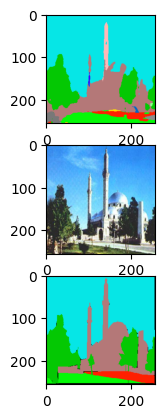

In [15]:
from scipy.io import loadmat
import matplotlib.pylab as plt
from scripts.utils import colorEncode
from PIL import Image




image_file = f'..\\data\\ADEChallengeData2016\\images\\validation\\ADE_val_00001551.jpg'
pred= test(image_file)
segm = Image.open(image_file.replace("images","annotations").replace("jpg","png"))
segm = segm.resize((256, 256), Image.NEAREST)
segm = segm_transform(segm).numpy()

pred_color = colorEncode(pred, loadmat('../data/color150.mat')['colors'])
annotated_color = colorEncode(segm, loadmat('../data/color150.mat')['colors'])


f, axarr = plt.subplots(3,1) 

axarr[0].imshow(pred_color)
axarr[1].imshow(Image.open(image_file).resize((256, 256), Image.NEAREST))
axarr[2].imshow(annotated_color)